In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters, report_fit

In [5]:
n_compartments = 3
source_concentration = 1
time_steps = 500
dt = 0.1
diffusion_rate = 0.2  # constant k_ij between all compartments

# init compartments
compartments = np.zeros(n_compartments)
source = source_concentration  # create inf source
concentration = []

# stolen ken code
for t in range(time_steps):
    concentration.append(np.concatenate(([source], compartments.copy())))
    
    # source ---> first compartment
    flux_source = diffusion_rate * (source - compartments[0]) * dt
    compartments[0] += flux_source

    # diffusion between compartments
    fluxes = np.zeros(n_compartments)
    for i in range(n_compartments - 1):
        flux = diffusion_rate * (compartments[i] - compartments[i + 1]) * dt
        fluxes[i] -= flux
        fluxes[i + 1] += flux
    compartments += fluxes

concentration = np.array(concentration)
time = np.linspace(0, time_steps * dt, time_steps) # time arr

In [ ]:
def sigmoid(t, L, k, t0):
    return L / (1 + np.exp(-k * (t - t0)))

def sigmoid_objective_function(params, t_obs, y_obs): # sigmoid from data + interpolation
    L = params['L'].value
    k = params['k'].value
    t0 = params['t0'].value

    y_model_full = sigmoid(t_obs, L, k, t0)
    # interpolate_model = interp1d(time, y_model_full, kind='cubic', bounds_error=False, fill_value="extrapolate")
    y_model = y_model_full #interpolate_model(t_obs)

    return y_obs - y_model # compute residuals to minimize later


def logistic_ODE(t, y, k = 1, a = 1):
    return (k/a)*y*(a-y)

a = 5
k = 2
r = 3
t_eval= np.linspace(0,10,100)
     
y0 = [a/(1 + np.exp(k*r))]   
sol = solve_ivp(logistic_ODE, (min(t_eval),max(t_eval)), y0 = y0, args=(k, a), t_eval=(t_eval), method='DOP853')

# def logistic_ODE_objective_function(params, t_obs, y_obs, compartment_i):
#     k = params['k'].value
#     a = params['a'].value
#     t0 = params['t0'].value

#     y_model_full = sigmoid(time, a, k, t0)
#     interpolate_model = interp1d(time, y_model_full, kind='cubic', bounds_error=False, fill_value="extrapolate")
#     y_model = interpolate_model(t_obs)

#     return y_obs - y_model # compute residuals to minimize later


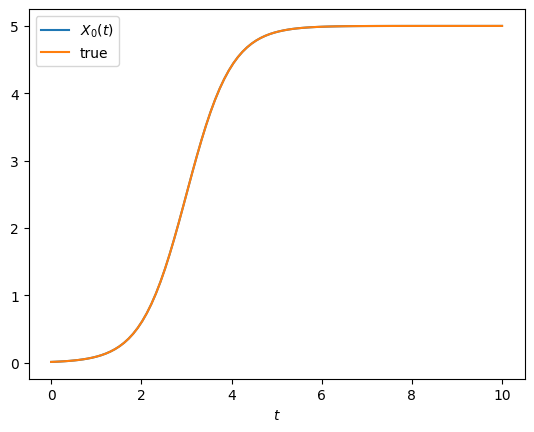

In [53]:
for i in range(sol.y.shape[0]):
    plt.plot(sol.t, sol.y[i], label=f'$X_{i}(t)$')
plt.xlabel('$t$') # the horizontal axis represents the time 


t = t_eval
sig = sigmoid(t, L = a, k = k, t0 = r)
plt.plot(t, sig, label = "true")
plt.legend() # show how the colors correspond to the components of X
plt.show()


In [62]:

from scipy.optimize import least_squares

def lsq_ODE(params, x, data, f_ODE=logistic_ODE):
    
    y0_ode = params['y0_ode'].value
    args_ode = []
    for key in params.keys():
        if key != 'y0_ode':
            args_ode.append(params[key].value)
            
    args_ode = tuple(args_ode)
    
    sol = solve_ivp(f_ODE, t_span=(min(x),max(x)), y0 = [y0_ode], args=args_ode, t_eval = x, method='DOP853')  
    
    return data - sol.y


params = Parameters()
params.add('y0_ode', value = 0.02)
params.add('k', value = 1)
params.add('a', value = 10)

params_direct = Parameters()
params_direct.add('L', value = params['a'].value)
params_direct.add('k', value = params['k'].value)
params_direct.add('t0', value = r)


min1 = minimize(lsq_ODE, params = params, args=(t_eval, sig), ftol=1e-20, gtol=1e-20, xtol=1e-20, max_nfev=20000) # fcn_kws= {'x':t_eval,'data': sig})#, 'f_ODE': logistic_ODE})
report_fit(min1)


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 255
    # data points      = 100
    # variables        = 3
    chi-square         = 0.61198803
    reduced chi-square = 0.00630915
    Akaike info crit   = -503.621274
    Bayesian info crit = -495.805764
##  Warning: uncertainties could not be estimated:
[[Variables]]
    y0_ode:  0.02915568 (init = 0.02)
    k:       1.72083494 (init = 1)
    a:       5.02612619 (init = 10)


In [44]:
min2 = minimize(sigmoid_objective_function, params = params_direct, args=(t_eval, sig), ftol=1e-10,max_nfev=20000) # fcn_kws= {'x':t_eval,'data': sig})#, 'f_ODE': logistic_ODE})
report_fit(min2)


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 100
    # variables        = 3
    chi-square         = 3.4920e-30
    reduced chi-square = 3.6000e-32
    Akaike info crit   = -7237.22406
    Bayesian info crit = -7229.40855
[[Variables]]
    L:   5.00000000 +/- 2.6397e-17 (0.00%) (init = 1)
    k:   2.00000000 +/- 7.7584e-17 (0.00%) (init = 1.5)
    t0:  3.00000000 +/- 2.2340e-17 (0.00%) (init = 3)
[[Correlations]] (unreported correlations are < 0.100)
    C(L, t0) = +0.3545
    C(L, k)  = -0.3167
    C(k, t0) = -0.1122


In [45]:
[a,k,r]

[5, 2, 3]

In [ ]:
[y0,k,a]

[[0.012363115783173872], 2, 5]

In [14]:
lsq_ODE(params=params, x=t_eval, data=sig)

array([[-0.98763688, -0.98487749, -0.9815045 , -0.97738259, -0.97234717,
        -0.96619831, -0.95869354, -0.94953948, -0.93838196, -0.92479485,
        -0.90826736, -0.88819015, -0.86384062, -0.83436802, -0.79877981,
        -0.75593104, -0.70451969, -0.64309161, -0.57006016, -0.48374642,
        -0.3824461 , -0.2645289 , -0.12857339,  0.02646493,  0.20106222,
         0.39493202,  0.60685895,  0.83459815,  1.07487738,  1.32352632,
         1.5757344 ,  1.82640888,  2.07057933,  2.30378184,  2.52236195,
         2.72365679,  2.90604627,  3.06888953,  3.21238022,  3.33735919,
         3.44511892,  3.53722432,  3.61536396,  3.68123667,  3.73647217,
         3.78258096,  3.82092723,  3.85271862,  3.87900764,  3.90070021,
         3.91856846,  3.93326523,  3.94533901,  3.95524819,  3.9633743 ,
         3.97003378,  3.97548837,  3.9799541 ,  3.98360891,  3.98659916,
         3.98904509,  3.99104539,  3.99268098,  3.99401819,  3.99511132,
         3.99600485,  3.99673517,  3.99733206,  3.9